In [2]:
import numpy as np
import pandas as pd
import os
import io
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as se
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_mutual_info_score,adjusted_rand_score,homogeneity_score
import hypertools as hyp
from collections import Counter
%matplotlib inline

In [3]:
import boto3
import sagemaker
session = sagemaker.Session()

In [31]:
#read files
csv_file = 'data/77_cancer_proteomes_CPTAC_itraq.csv'
csv_file2 = 'data/clinical_data_breast_cancer.csv'
csv_file3 = 'data/PAM50_proteins.csv'
proteome_df = pd.read_csv(csv_file,header=0,index_col = 0)
clinical_df = pd.read_csv(csv_file2,header=0,index_col = 0)
pam50_df = pd.read_csv(csv_file3,header=0)

In [32]:
#print out stats about data
print('(proteome_df) rows, cols: ', proteome_df.shape)
print('(clinical_df) rows, cols: ', clinical_df.shape)
print('(pam50_df) rows, cols: ', pam50_df.shape)

(proteome_df) rows, cols:  (12553, 85)
(clinical_df) rows, cols:  (105, 29)
(pam50_df) rows, cols:  (100, 4)


In [6]:
# print out the first few rows of proteome_df
proteome_df.head()

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [36]:
#statistics of proteome_df
proteome_df.describe(include='all')

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
count,10773,12553,11334.000000,11335.000000,11334.000000,12024.000000,12025.000000,11833.000000,11833.000000,11732.000000,...,11477.000000,10324.000000,10324.000000,10324.000000,9694.000000,9693.000000,9697.000000,10912.000000,10885.000000,10913.000000
unique,10062,12472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,FHL1,NADH dehydrogenase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.133079,0.128822,-0.440764,-0.729233,-0.039436,0.115353,-0.618354,-0.305320,...,-0.677085,-0.103215,-0.021222,-0.100912,0.488502,-0.368762,-0.050669,0.069555,-0.298170,0.310974
std,NaN,NaN,1.734231,1.579845,1.634930,2.422452,1.353505,1.652918,2.281818,1.567687,...,2.018394,1.570606,1.656519,1.628017,1.658080,1.453737,1.716237,1.950822,1.307027,1.706759
min,NaN,NaN,-12.466750,-13.156553,-9.911008,-24.553794,-15.004199,-12.956961,-16.640848,-18.710032,...,-12.497832,-12.152747,-11.874381,-11.128835,-8.772601,-10.427946,-12.967849,-12.609296,-9.058864,-6.328154
25%,NaN,NaN,-0.656376,-0.583835,-1.330525,-1.266591,-0.671173,-0.679944,-1.278707,-0.991299,...,-1.731881,-0.815820,-0.740905,-0.805968,-0.497485,-1.063180,-0.934818,-0.867155,-1.056363,-0.652571
50%,NaN,NaN,0.078915,0.116448,-0.318937,-0.296430,0.024160,0.088055,-0.157218,-0.231885,...,-0.444306,-0.056808,0.023619,-0.037659,0.314206,-0.204129,-0.079784,0.052313,-0.191285,0.137007
75%,NaN,NaN,0.905641,0.853163,0.489641,0.449590,0.719492,0.929197,0.670727,0.483663,...,0.500677,0.657177,0.800701,0.714075,1.276655,0.521043,0.757374,1.009641,0.574868,1.059485


In [7]:
proteome_df_num = proteome_df.select_dtypes(include = ['float64', 'int64'])# get columns that are numerical
proteome_df_num.head()

,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


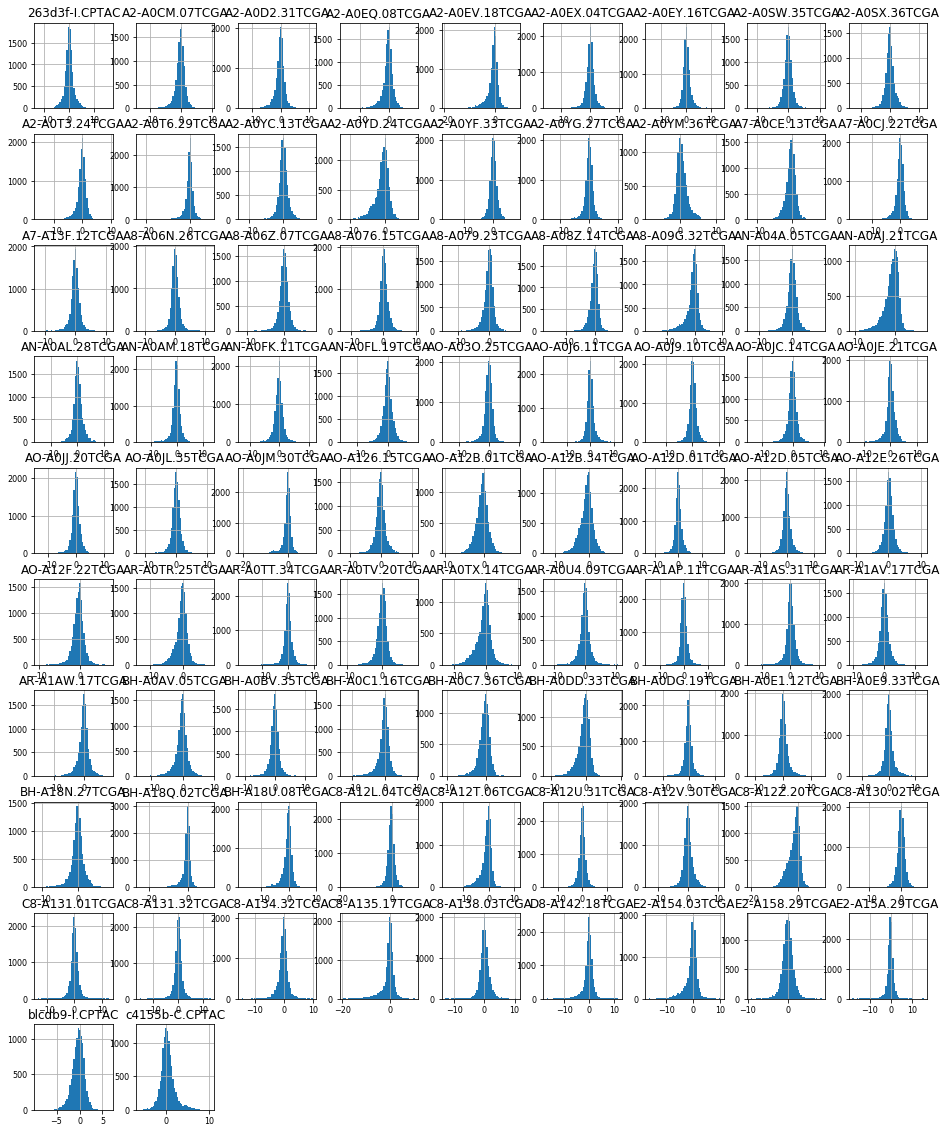

In [8]:
#look at the distribution of proteoin ecpression in all breast cancer samples
proteome_df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

In [10]:
# print out the first few rows of clinical_df
clinical_df.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,...,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2


In [37]:
#statistics of clinical_df
clinical_df.describe(include='all')

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
count,105,105.000000,105,105,105,105,105,105,105,105,...,105,105.000000,105.000000,105.000000,105.000000,105,105.000000,105.000000,105.000000,105.000000
unique,2,NaN,3,2,3,4,2,4,2,2,...,4,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN
top,FEMALE,NaN,Positive,Positive,Negative,T2,T_Other,N0,Negative,M0,...,Luminal B,NaN,NaN,NaN,NaN,Basal,NaN,NaN,NaN,NaN
freq,103,NaN,68,54,77,65,90,53,53,103,...,33,NaN,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN
mean,NaN,58.685714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-4.885714,-7.180952,4.000000,3.342857,NaN,2.590476,2.742857,1.980952,2.352381
std,NaN,13.066630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.558074,5.022605,1.593255,1.406226,NaN,1.342323,1.074428,0.970537,1.091761
min,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-12.000000,-13.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000
25%,NaN,49.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-6.000000,-12.000000,3.000000,2.000000,NaN,1.000000,2.000000,1.000000,1.000000
50%,NaN,58.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-5.000000,-6.000000,4.000000,4.000000,NaN,3.000000,3.000000,2.000000,2.000000
75%,NaN,67.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-3.000000,-2.000000,5.000000,4.000000,NaN,3.000000,4.000000,3.000000,3.000000


In [11]:
# print out the first few rows of pam50_df
pam50_df.head()


,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160


In [38]:
#statistics of pam50_df
pam50_df.describe(include='all')

,GeneSymbol,RefSeqProteinID,Species,Gene Name
count,100,100,100,100
unique,50,100,1,50
top,NAT1,NP_001116214,Homo sapiens,Mdm2 p53 binding protein homolog (mouse)
freq,9,1,100,9


In [12]:
#drop feature not needed for analysis
drop=['gene_symbol','gene_name']
proteome_df.drop(drop,axis=1,inplace=True)
print('(proteome_df stats after drop) rows, cols: ', proteome_df.shape)

(proteome_df stats after drop) rows, cols:  (12553, 83)


In [13]:
#features in proteomes_df
print('Features: \n', proteome_df.columns.values)

Features: 
 ['AO-A12D.01TCGA' 'C8-A131.01TCGA' 'AO-A12B.01TCGA' 'BH-A18Q.02TCGA'
 'C8-A130.02TCGA' 'C8-A138.03TCGA' 'E2-A154.03TCGA' 'C8-A12L.04TCGA'
 'A2-A0EX.04TCGA' 'AO-A12D.05TCGA' 'AN-A04A.05TCGA' 'BH-A0AV.05TCGA'
 'C8-A12T.06TCGA' 'A8-A06Z.07TCGA' 'A2-A0CM.07TCGA' 'BH-A18U.08TCGA'
 'A2-A0EQ.08TCGA' 'AR-A0U4.09TCGA' 'AO-A0J9.10TCGA' 'AR-A1AP.11TCGA'
 'AN-A0FK.11TCGA' 'AO-A0J6.11TCGA' 'A7-A13F.12TCGA' 'BH-A0E1.12TCGA'
 'A7-A0CE.13TCGA' 'A2-A0YC.13TCGA' 'AO-A0JC.14TCGA' 'A8-A08Z.14TCGA'
 'AR-A0TX.14TCGA' 'A8-A076.15TCGA' 'AO-A126.15TCGA' 'BH-A0C1.16TCGA'
 'A2-A0EY.16TCGA' 'AR-A1AW.17TCGA' 'AR-A1AV.17TCGA' 'C8-A135.17TCGA'
 'A2-A0EV.18TCGA' 'AN-A0AM.18TCGA' 'D8-A142.18TCGA' 'AN-A0FL.19TCGA'
 'BH-A0DG.19TCGA' 'AR-A0TV.20TCGA' 'C8-A12Z.20TCGA' 'AO-A0JJ.20TCGA'
 'AO-A0JE.21TCGA' 'AN-A0AJ.21TCGA' 'A7-A0CJ.22TCGA' 'AO-A12F.22TCGA'
 'A8-A079.23TCGA' 'A2-A0T3.24TCGA' 'A2-A0YD.24TCGA' 'AR-A0TR.25TCGA'
 'AO-A03O.25TCGA' 'AO-A12E.26TCGA' 'A8-A06N.26TCGA' 'A2-A0YG.27TCGA'
 'BH-A18N.27TCGA' 'AN-

In [14]:
#rename column name to match patient ID between proteome_df and clinical_df
import re
proteome_df.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
proteome_df.head()

,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,TCGA-C8-A12L,TCGA-A2-A0EX,TCGA-AO-A12D,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [15]:
#features in proteome_df
print('Features: \n', proteome_df.columns.values)

Features: 
 ['TCGA-AO-A12D' 'TCGA-C8-A131' 'TCGA-AO-A12B' 'TCGA-BH-A18Q'
 'TCGA-C8-A130' 'TCGA-C8-A138' 'TCGA-E2-A154' 'TCGA-C8-A12L'
 'TCGA-A2-A0EX' 'TCGA-AO-A12D' 'TCGA-AN-A04A' 'TCGA-BH-A0AV'
 'TCGA-C8-A12T' 'TCGA-A8-A06Z' 'TCGA-A2-A0CM' 'TCGA-BH-A18U'
 'TCGA-A2-A0EQ' 'TCGA-AR-A0U4' 'TCGA-AO-A0J9' 'TCGA-AR-A1AP'
 'TCGA-AN-A0FK' 'TCGA-AO-A0J6' 'TCGA-A7-A13F' 'TCGA-BH-A0E1'
 'TCGA-A7-A0CE' 'TCGA-A2-A0YC' 'TCGA-AO-A0JC' 'TCGA-A8-A08Z'
 'TCGA-AR-A0TX' 'TCGA-A8-A076' 'TCGA-AO-A126' 'TCGA-BH-A0C1'
 'TCGA-A2-A0EY' 'TCGA-AR-A1AW' 'TCGA-AR-A1AV' 'TCGA-C8-A135'
 'TCGA-A2-A0EV' 'TCGA-AN-A0AM' 'TCGA-D8-A142' 'TCGA-AN-A0FL'
 'TCGA-BH-A0DG' 'TCGA-AR-A0TV' 'TCGA-C8-A12Z' 'TCGA-AO-A0JJ'
 'TCGA-AO-A0JE' 'TCGA-AN-A0AJ' 'TCGA-A7-A0CJ' 'TCGA-AO-A12F'
 'TCGA-A8-A079' 'TCGA-A2-A0T3' 'TCGA-A2-A0YD' 'TCGA-AR-A0TR'
 'TCGA-AO-A03O' 'TCGA-AO-A12E' 'TCGA-A8-A06N' 'TCGA-A2-A0YG'
 'TCGA-BH-A18N' 'TCGA-AN-A0AL' 'TCGA-A2-A0T6' 'TCGA-E2-A158'
 'TCGA-E2-A15A' 'TCGA-AO-A0JM' 'TCGA-C8-A12V' 'TCGA-A2-A0D2'
 'TCGA-C8-A1

In [16]:
proteome_df = proteome_df.transpose()
proteome_df.head()

RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997


In [17]:
## Drop clinical entries for samples not in our protein data set
clinical_df = clinical_df.loc[[x for x in clinical_df.index.tolist() if x in proteome_df.index],:]
clinical_df.shape

(77, 29)

In [18]:
#mearge proteome_df and clinical_df
proteom_clinical_merge = proteome_df.merge(clinical_df,left_index=True,right_index=True)

cleaned = proteom_clinical_merge # change name
cleaned.shape

(80, 12582)

In [19]:
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
cleaned_numerical = cleaned.loc[:,[x for x in cleaned.columns if bool(re.search("NP_|XP_",x)) == True]]
cleaned_numerical.shape

(80, 12546)

In [20]:
## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_numerical_p50 = cleaned_numerical.iloc[:,cleaned_numerical.columns.isin(pam50_df['RefSeqProteinID'])]
processed_numerical_p50.shape

(80, 43)

In [21]:
# print out the first few rows of processed_numerical_p50
processed_numerical_p50.head()

,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,...,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,-1.292949,3.541400,3.177722,NaN,-1.792547,NaN,NaN,2.516489,2.556897,NaN
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,NaN,-0.714133
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,...,-1.410193,0.702364,-1.402538,NaN,NaN,1.934688,NaN,0.798041,2.003576,NaN
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,...,0.018893,-1.574649,-4.515280,NaN,NaN,2.049328,NaN,-0.266769,-3.201798,-7.724769
TCGA-A2-A0EX,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,...,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-2.079011,-3.046991,2.554537,-0.443199


In [22]:
#impute missing values using KNN
from sklearn.impute import KNNImputer
index_list=processed_numerical_p50.index.values
imputer = KNNImputer(n_neighbors=3)
cleaned_numerical_p50= pd.DataFrame(imputer.fit_transform(processed_numerical_p50),columns = processed_numerical_p50.columns,index=index_list)
processed_numerical_p50.shape

(80, 43)

In [23]:
#print out first few rows of cleaned_numerical_p50
cleaned_numerical_p50.head()

,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,...,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,-1.292949,3.541400,3.177722,1.016209,-1.792547,-2.054827,-0.359917,2.516489,2.556897,-1.720350
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,0.061541,-0.714133
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,...,-1.410193,0.702364,-1.402538,2.162124,0.106154,1.934688,-1.376025,0.798041,2.003576,-0.527998
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,...,0.018893,-1.574649,-4.515280,-0.711478,-2.064634,2.049328,-0.346339,-0.266769,-3.201798,-7.724769
TCGA-A2-A0EX,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,...,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-2.079011,-3.046991,2.554537,-0.443199


In [24]:
cleaned_numerical_p50.columns.values

array(['NP_057427', 'NP_002408', 'NP_000415', 'NP_000413', 'NP_000517',
       'NP_004439', 'NP_005219', 'NP_058519', 'NP_058518', 'NP_001116539',
       'NP_061155', 'NP_001035932', 'NP_077006', 'NP_000917', 'NP_065178',
       'NP_006836', 'NP_006614', 'NP_001784', 'NP_006092', 'NP_001153651',
       'NP_001159403', 'NP_000116', 'NP_004314', 'NP_060601', 'NP_005931',
       'NP_003003', 'NP_113611', 'NP_002002', 'NP_004487', 'NP_008950',
       'NP_114172', 'NP_001062', 'NP_001444', 'NP_057547', 'NP_054895',
       'NP_001246', 'NP_055606', 'NP_036451', 'NP_000624', 'NP_569082',
       'NP_001159', 'NP_001229', 'NP_002458'], dtype=object)

In [49]:
# Save to local directory before saving to S3
#make sure folder 'mydata' exist
session = sagemaker.Session()
data_dir = 'mydata'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [65]:
#make csv
cleaned_numerical_p50.to_csv(os.path.join(data_dir, 'processed_pam50.csv'), header=False, index=False)

In [66]:
 #Uploading the local file to S3
prefix = 'cleaned_pam50

pam50_location = session.upload_data(os.path.join(data_dir, 'processed_pam50.csv'), key_prefix=prefix)

Processed_pam50.csv has a large dimension. Unsupervised algorithm finds relationship in data. High dimension could leads to noisy clustering. Therefore, algorithm like K-means might have challenges to determine which  dimension to pay attention to. As a result i used PCA to reduce the dimension of Processed_pam50 by only selecteing features that cause most variance.

In [67]:
from sagemaker import get_execution_role
# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::524214819252:role/service-role/AmazonSageMaker-ExecutionRole-20201121T153853


In [68]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-west-1-524214819252



In [69]:
#define location to store model artifacts
prefix = 'pam50_pca'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-west-1-524214819252/pam50_pca/


In [70]:
# define a PCA model
from sagemaker import PCA

# current features - 1
N_COMPONENTS=42

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [71]:
# convert df to np array
train_data_np = cleaned_numerical_p50.values.astype('float32')

# convert to RecordSet format for fast processing
formatted_train_data = pca_SM.record_set(train_data_np)

In [72]:
%%time
pca_SM.fit(formatted_train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-22 11:08:48 Starting - Starting the training job...
2020-11-22 11:08:50 Starting - Launching requested ML instances......
2020-11-22 11:10:18 Starting - Preparing the instances for training.........
2020-11-22 11:11:46 Downloading - Downloading input data
2020-11-22 11:11:46 Training - Downloading the training image...
2020-11-22 11:12:17 Uploading - Uploading generated training model
2020-11-22 11:12:17 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/22/2020 11:12:08 INFO 139673974175552] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[11/22/2020 11:12:08 INFO 139673974175552] Merging with provided 

Training seconds: 52
Billable seconds: 52
CPU times: user 460 ms, sys: 20.1 ms, total: 480 ms
Wall time: 3min 41s


In [74]:
#Accessing the PCA Model Attributes
training_job_name='pca-2020-11-22-11-08-48-697'#name of the training job

# where the model is saved
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')


pam50_pca/pca-2020-11-22-11-08-48-697/output/model.tar.gz


2304

In [75]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# print the params
print(pca_model_params)

{'s': 
[ 1.1917434  1.371738   3.0897684  3.243173   3.7210505  4.1653056
  4.42132    4.5760713  4.7100544  5.2993217  5.733301   5.930828
  6.471568   6.910189   7.469886   7.8746543  8.7045555  9.203444
  9.574463   9.769288  10.110699  10.700724  11.230308  11.491107
 12.415508  13.088305  14.047138  15.393173  15.999033  16.659426
 17.01245   19.361591  19.670303  20.531563  23.598465  23.739342
 29.139395  31.47319   33.316944  39.071617  49.074886  82.66185  ]
<NDArray 42 @cpu(0)>, 'v': 
[[ 1.84499323e-02  1.19264998e-01 -4.68122274e-01 ...  1.41594067e-01
   1.01312056e-01  6.24067299e-02]
 [ 2.34968849e-02  9.78200734e-02  1.87613629e-02 ...  2.16111362e-01
   3.52186076e-02  1.25390455e-01]
 [-2.34356834e-04  1.95910186e-02 -3.26415151e-02 ... -1.93261951e-01
   4.21237081e-01  1.21700063e-01]
 ...
 [-5.32166995e-02 -8.52633417e-02 -2.85740156e-04 ...  9.42926481e-02
   1.26432721e-02  9.84599143e-02]
 [ 4.53456417e-02  5.88777289e-02  4.59779017e-02 ...  7.47021362e-02
   1.

In [76]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [78]:
# get top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 43-n

# print a selection of s
print(s.iloc[start_idx:, :])



            0
37  31.473190
38  33.316944
39  39.071617
40  49.074886
41  82.661850


In [79]:
# Calculate explained variance for the top n principal components
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 43-3 = 40, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [89]:
n_top_components = 10 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)


Explained variance:  0.8301719


In [90]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=13):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

In [92]:
# features
features_list = cleaned_numerical_p50.columns.values
print('Features: \n', features_list)

Features: 
 ['NP_057427' 'NP_002408' 'NP_000415' 'NP_000413' 'NP_000517' 'NP_004439'
 'NP_005219' 'NP_058519' 'NP_058518' 'NP_001116539' 'NP_061155'
 'NP_001035932' 'NP_077006' 'NP_000917' 'NP_065178' 'NP_006836'
 'NP_006614' 'NP_001784' 'NP_006092' 'NP_001153651' 'NP_001159403'
 'NP_000116' 'NP_004314' 'NP_060601' 'NP_005931' 'NP_003003' 'NP_113611'
 'NP_002002' 'NP_004487' 'NP_008950' 'NP_114172' 'NP_001062' 'NP_001444'
 'NP_057547' 'NP_054895' 'NP_001246' 'NP_055606' 'NP_036451' 'NP_000624'
 'NP_569082' 'NP_001159' 'NP_001229' 'NP_002458']


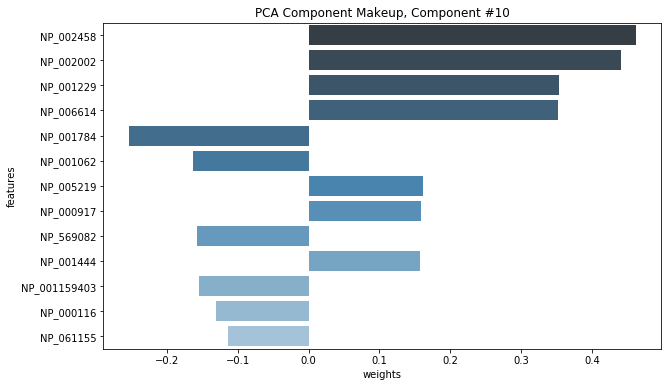

In [142]:
# display makeup of tenth component
num=10
display_component(v, features_list, component_num=num, n_weights=13)


In [99]:
%%time
# deploy model
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


--------------!CPU times: user 264 ms, sys: 18.9 ms, total: 283 ms
Wall time: 7min 3s


In [100]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [101]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: -0.0817866399884224
      values: 0.31006187200546265
      values: -0.0012174248695373535
      values: -0.1745189130306244
      values: 0.15669019520282745
      values: -0.9717267751693726
      values: -0.8598654270172119
      values: 0.9765841960906982
      values: 0.1947551965713501
      values: -0.5705859661102295
      values: 1.4446907043457031
      values: -0.5407345294952393
      values: -0.507465124130249
      values: -1.4295520782470703
      values: 0.8477332592010498
      values: 0.369419127702713
      values: -0.02485901117324829
      values: -0.4987913966178894
      values: -0.648646354675293
      values: 0.3567503094673157
      values: -1.0983972549438477
      values: -0.5673134922981262
      values: 1.008056879043579
      values: 2.0654561519622803
      values: -1.4249448776245117
      values: -3.062466621398926
      values: -2.1796023845672607
      values: 2.4557578563690186

In [106]:
# create dimensionality-reduced data
def create_transformed_df(train_pca,cleaned_numerical_p50, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param cleaned_numerical_p50: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    pam50_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        pam50_transformed=pam50_transformed.append([list(components)])

    # index by samples, just like cleaned_numerical_p50
    pam50_transformed.index=cleaned_numerical_p50.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    pam50_transformed = pam50_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return pam50_transformed.iloc[:, ::-1]

In [107]:
# specify top n
top_n = 10

# call function and create a new dataframe
pam50_transformed = create_transformed_df(train_pca, cleaned_numerical_p50, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7','c_8','c_9','c_10']
pam50_transformed.columns=PCA_list 

# print result
pam50_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10
TCGA-A2-A0CM,15.431227,7.821354,3.275651,-0.258920,-0.663338,2.276361,-1.098618,-3.862329,-0.172877,-1.239921
TCGA-A2-A0D2,17.540833,10.430332,3.052728,0.610948,5.047405,-2.981493,-2.179122,-0.413820,3.809283,-0.649967
TCGA-A2-A0EQ,11.224703,-11.511736,4.251035,0.814535,2.048342,5.471150,-1.603099,4.396433,-3.651326,5.031355
TCGA-A2-A0EV,-3.411963,-3.715506,-8.008796,1.863707,5.557964,-2.323494,-1.074858,1.307587,-2.408176,-3.601288
TCGA-A2-A0EX,-10.844254,3.940020,-3.991118,5.367975,-3.573775,-2.316356,-0.919680,0.015050,1.796520,2.879889


In [108]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

### See section **"determining the optimal K"**on how it was decided to use K=3

In [ ]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 3

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

In [115]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = pam50_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [116]:
%%time
# train kmeans
kmeans.fit(kmeans_formatted_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-22 15:49:51 Starting - Starting the training job...
2020-11-22 15:49:53 Starting - Launching requested ML instances......
2020-11-22 15:51:20 Starting - Preparing the instances for training.........
2020-11-22 15:52:48 Downloading - Downloading input data
2020-11-22 15:52:48 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/22/2020 15:53:06 INFO 140186590140224] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'e


2020-11-22 15:53:16 Uploading - Uploading generated training model
2020-11-22 15:53:16 Completed - Training job completed
Training seconds: 49
Billable seconds: 49
CPU times: user 483 ms, sys: 13.1 ms, total: 496 ms
Wall time: 3min 41s


In [117]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------!CPU times: user 347 ms, sys: 13.6 ms, total: 361 ms
Wall time: 9min 33s


In [118]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

In [121]:
# print cluster info for first data point
data_idx = 0

print('Breast cancer samples is: ', pam50_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

Breast cancer samples is:  TCGA-A2-A0CM

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 9.834161758422852
    }
  }
}



In [122]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [123]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

0.0    31
2.0    29
1.0    20
Name: 0, dtype: int64


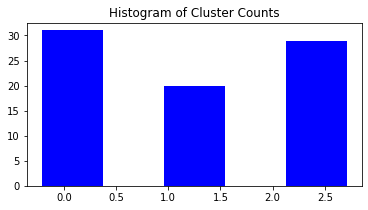

In [130]:
# another method of visualizing the distribution
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=3,  range=(-0.5, 3), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()



In [131]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

In [132]:
# download and unzip the kmeans model file
kmeans_job_name = 'kmeans-2020-11-22-15-49-51-609'

model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [133]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[ 1.0247163  -4.250535   -0.40561295 -0.2556048  -0.95310754  0.4435493
   1.0823066  -1.5284852  -0.07151348 -0.4659324 ]
 [10.562536    3.0792322   0.20631823  1.0966222   0.81871295  0.22663143
  -0.53723484  1.6432543   0.09486013  0.23128223]
 [-9.935396    1.7156898   1.1775763  -0.27663106 -0.14089476 -0.03446114
  -1.0239221   0.03436418 -0.03767359  0.47704962]]
<NDArray 3x10 @cpu(0)>]


In [135]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=pam50_transformed.columns
display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10
0,1.024716,-4.250535,-0.405613,-0.255605,-0.953108,0.443549,1.082307,-1.528485,-0.071513,-0.465932
1,10.562536,3.079232,0.206318,1.096622,0.818713,0.226631,-0.537235,1.643254,0.094860,0.231282
2,-9.935396,1.715690,1.177576,-0.276631,-0.140895,-0.034461,-1.023922,0.034364,-0.037674,0.477050


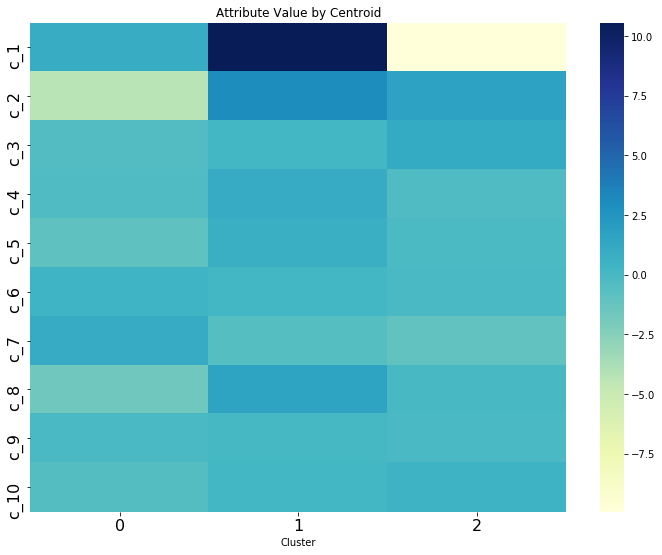

In [136]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [139]:
# add a 'labels' column to the dataframe
pam50_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_samples = pam50_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_samples.head(20)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,labels
TCGA-E2-A15A,2.526233,-1.865917,-0.248545,-1.960654,0.597450,4.866226,-1.779574,-5.158759,-1.946876,-3.345338,0
TCGA-BH-A18U,0.086137,-7.251539,-2.824507,-11.536124,2.548779,-0.472973,-1.105456,0.992275,-2.793262,1.580080,0
TCGA-A8-A09G,4.977205,-6.109919,-1.675800,2.431902,-6.225111,-0.316704,0.042482,-2.327578,3.065425,0.173311,0
TCGA-BH-A0E1,0.919566,2.930552,-2.980960,-8.083254,4.206292,3.997974,1.124142,4.754670,4.357474,1.830412,0
TCGA-AN-A0AJ,-2.693129,-0.446555,4.572223,-2.034828,4.669247,-4.071869,3.641179,-0.664480,1.383053,-3.187300,0
TCGA-BH-A0DG,5.766927,-3.984986,-1.658479,0.802425,0.034999,9.220609,4.661813,-3.538784,0.936532,1.945454,0
TCGA-AN-A0AM,6.756847,-9.172791,3.175636,2.520608,5.105463,2.906744,3.463498,-5.427151,-5.467593,-0.255589,0
TCGA-AO-A12D,3.736318,-4.790320,0.663358,-0.792160,-11.286147,-5.016804,-1.918180,-0.695155,0.477308,-0.333053,0
TCGA-BH-A0BV,-3.277548,0.983486,-1.957721,5.340608,-1.269208,2.730734,2.793020,-2.553056,3.052138,2.263925,0
TCGA-AR-A0TX,1.399874,-6.585283,-10.517982,0.016541,1.936033,-9.476703,1.785480,-1.431738,-1.548554,4.249719,0


In [141]:
# get all cancer samples with label == 1
cluster=pam50_transformed[pam50_transformed['labels']==1]
cluster.head(10)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,labels
TCGA-A2-A0CM,15.431227,7.821354,3.275651,-0.258920,-0.663338,2.276361,-1.098618,-3.862329,-0.172877,-1.239921,1
TCGA-A2-A0D2,17.540833,10.430332,3.052728,0.610948,5.047405,-2.981493,-2.179122,-0.413820,3.809283,-0.649967,1
TCGA-A2-A0SX,11.552851,9.341712,-1.669841,3.069021,-0.234906,0.228421,-1.639586,-2.037727,-2.515136,-0.471951,1
TCGA-A2-A0YM,5.335741,5.227454,-1.837246,2.235204,1.071607,-0.707517,0.407242,2.119813,0.834058,0.943221,1
TCGA-A7-A0CE,11.359938,11.862225,-0.694109,-1.826860,0.200708,-2.222432,-0.061277,-1.930364,-0.629419,1.865360,1
TCGA-AN-A0AL,12.780554,0.997832,4.327280,1.653694,-1.636817,-0.098772,2.336394,4.979963,-4.383259,-0.615168,1
TCGA-AN-A0FL,8.854290,-1.620613,-1.115478,1.522399,1.430122,-0.232232,1.622730,7.356537,0.828649,1.619082,1
TCGA-AO-A0JL,6.084960,1.017797,3.656463,3.179948,3.323614,-2.230402,-0.453600,3.114451,4.877450,1.569065,1
TCGA-AO-A12F,7.110306,7.962451,1.850689,0.744722,-0.219388,-1.540363,3.195784,0.539027,-0.825142,-0.871113,1
TCGA-AR-A0U4,10.691326,-2.300972,5.453691,3.447454,2.800859,4.362239,-3.140379,5.367043,1.954380,1.654087,1


## Determining the optimal K

In [169]:
from sklearn.cluster import KMeans
n_clusters = [2,3,4,5,6,7,8,10]
def compare_k_means(k_list,data):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k, n_jobs=4)
        clusterer.fit(data)
        ## The higher (up to 1) the better
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(silhouette_score(data, clusterer.labels_), 4)))
        ## The higher (up to 1) the better
        print("Homogeneity score for k == %s: %s" % (
        k, round(homogeneity_score(proteom_clinical_merge['PAM50 mRNA'], clusterer.labels_),4)))
        print("Ajusted Rand score for k == %s: %s" % (
        k, round(adjusted_rand_score(proteom_clinical_merge['PAM50 mRNA'], clusterer.labels_),4)))
        print("------------------------")


In [151]:
compare_k_means(n_clusters,cleaned_numerical_p50)

Silhouette Coefficient for k == 2: 0.2106
Homogeneity score for k == 2: 0.2073
Ajusted Rand score for k == 2: 0.2213
------------------------
Silhouette Coefficient for k == 3: 0.1755
Homogeneity score for k == 3: 0.4159
Ajusted Rand score for k == 3: 0.3835
------------------------
Silhouette Coefficient for k == 4: 0.1504
Homogeneity score for k == 4: 0.421
Ajusted Rand score for k == 4: 0.3442
------------------------
Silhouette Coefficient for k == 5: 0.1407
Homogeneity score for k == 5: 0.4975
Ajusted Rand score for k == 5: 0.4025
------------------------
Silhouette Coefficient for k == 6: 0.1208
Homogeneity score for k == 6: 0.4655
Ajusted Rand score for k == 6: 0.2471
------------------------
Silhouette Coefficient for k == 7: 0.1305
Homogeneity score for k == 7: 0.5188
Ajusted Rand score for k == 7: 0.3053
------------------------
Silhouette Coefficient for k == 8: 0.108
Homogeneity score for k == 8: 0.541
Ajusted Rand score for k == 8: 0.2519
------------------------
Silhouett

In [28]:
from sklearn.cluster import Birch
n_clusters = [2,3,4,5,6,7,8,10]
def compare_Birch(k_list,data):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = Birch(n_clusters=k)
        clusterer.fit(data)
        ## The higher (up to 1) the better
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(silhouette_score(data, clusterer.labels_), 4)))
        ## The higher (up to 1) the better
        print("Homogeneity score for k == %s: %s" % (
        k, round(homogeneity_score(proteom_clinical_merge['PAM50 mRNA'], clusterer.labels_),4)))
        print("Ajusted Rand score for k == %s: %s" % (
        k, round(adjusted_rand_score(proteom_clinical_merge['PAM50 mRNA'], clusterer.labels_),4)))
        print("------------------------")

In [29]:
compare_Birch(n_clusters,cleaned_numerical_p50)

Silhouette Coefficient for k == 2: 0.1991
Homogeneity score for k == 2: 0.2029
Ajusted Rand score for k == 2: 0.208
------------------------
Silhouette Coefficient for k == 3: 0.1725
Homogeneity score for k == 3: 0.4097
Ajusted Rand score for k == 3: 0.3846
------------------------
Silhouette Coefficient for k == 4: 0.1367
Homogeneity score for k == 4: 0.4279
Ajusted Rand score for k == 4: 0.3311
------------------------
Silhouette Coefficient for k == 5: 0.1385
Homogeneity score for k == 5: 0.5429
Ajusted Rand score for k == 5: 0.3926
------------------------
Silhouette Coefficient for k == 6: 0.1407
Homogeneity score for k == 6: 0.6039
Ajusted Rand score for k == 6: 0.4226
------------------------
Silhouette Coefficient for k == 7: 0.127
Homogeneity score for k == 7: 0.6226
Ajusted Rand score for k == 7: 0.3888
------------------------
Silhouette Coefficient for k == 8: 0.1153
Homogeneity score for k == 8: 0.6271
Ajusted Rand score for k == 8: 0.3226
------------------------
Silhouet

In [25]:
labels_3 = hyp.cluster(cleaned_numerical_p50, n_clusters = 3)
set(labels_3)

{0, 1, 2}

In [35]:
labels_Birch = hyp.cluster(cleaned_numerical_p50, cluster='Birch')

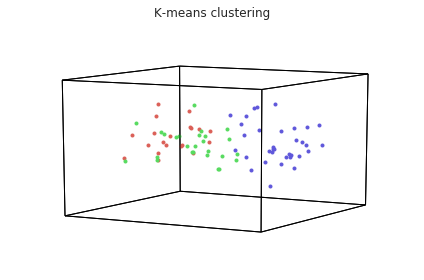

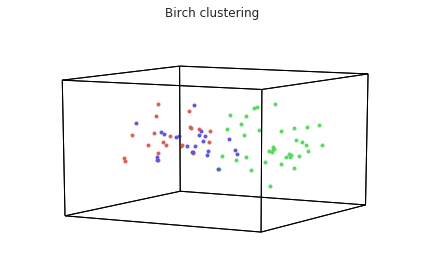

In [38]:
geo = hyp.plot(cleaned_numerical_p50, '.', hue=labels_3, title='K-means clustering')
geo = hyp.plot(cleaned_numerical_p50, '.', hue=labels_Birch, title='Birch clustering')